!kaggle competitions download -c digit-recognizer

!unzip -x ./digit-recognizer.zip

In [1]:
from typing import Tuple
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.optim.lr_scheduler import StepLR
from torchvision.datasets import MNIST
import torchvision
from sklearn.model_selection import train_test_split
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

# Device agnostic code

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_device(device)
print(f"default device set to {device}")

default device set to cpu


In [3]:
train_df = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
test_df = pd.read_csv("/kaggle/input/digit-recognizer/test.csv")

In [4]:
class MNIST(Dataset):
    def __init__(self, df: pd.DataFrame):
        self.dataset = df
    
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        inputs = torch.tensor(self.dataset.drop(columns=["label"]).iloc[idx].to_numpy().reshape(1, 28, 28), dtype=torch.float32)
        label = torch.tensor(self.dataset["label"].iloc[idx], dtype=torch.long)

        return (inputs, label)

In [5]:
train_split, val_split = train_test_split(train_df, test_size=0.2, shuffle=True)
train_dataset = MNIST(df=train_split)
val_dataset = MNIST(df=val_split)

train_dataset[0]

(tensor([[[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
             0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
             0.,   0.,   0.,   0.,   0.,   0.],
          [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
             0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
             0.,   0.,   0.,   0.,   0.,   0.],
          [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
             0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
             0.,   0.,   0.,   0.,   0.,   0.],
          [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
             0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
             0.,   0.,   0.,   0.,   0.,   0.],
          [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
             0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
             0.,   0.,   0.,   0.,   0

In [6]:
train_dataloader = DataLoader(dataset=train_dataset, batch_size=8, generator=torch.Generator(device=device), shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=32, generator=torch.Generator(device=device), shuffle=True)

In [7]:
next(iter(val_dataloader))

[tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         ...,
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ..

torch.Size([28, 28, 1])
label is 4


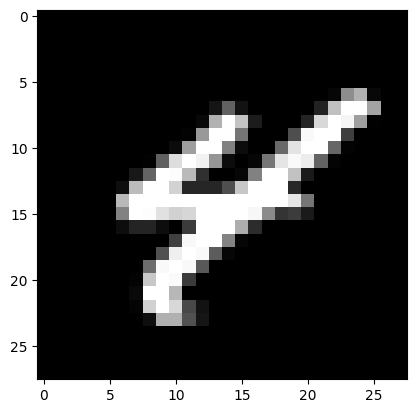

In [8]:
def plot_random_image(dataset):
    x = torch.randint(0, len(dataset), size=(1, )).item()
    image = dataset[x][0] # C, W, H
    print(image.permute(1, 2, 0).shape)
    plt.imshow(image.permute(1, 2, 0).cpu().numpy(), cmap="gray") # W, H, C
    print(f"label is {dataset[x][1]}")

plot_random_image(dataset=val_dataset)

https://poloclub.github.io/cnn-explainer/

In [9]:
# for starters, I will be assuming patch_size and img_size are both squares (images of same width and height)
class PatchEmbedding(nn.Module):
    def __init__(self, img_size: Tuple[int, int], patch_size: Tuple[int, int], in_channels: int, n_embd: int):
        super(PatchEmbedding, self).__init__()

        self.n_embd = n_embd
        self.img_size = img_size
        self.patch_size = patch_size

        # For an image of size 16x16 and patch size 4x4:
        # We divide the image size by the patch size to get the number of patches along each dimension
        # (16 / 4) * (16 / 4) = 4 * 4 = 16 patches in total to cover the entire image
        self.n_patches = (img_size[0] // patch_size[0]) * (img_size[1] // patch_size[1])

        # The Conv2D layer's filter will move patch_size pixels horizontally and vertically because
        # the stride is set to patch_size. This creates non-overlapping patches of size patch_size.
        self.projection = nn.Conv2d(in_channels=in_channels, kernel_size=patch_size, stride=patch_size, out_channels=n_embd)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x is of shape (B, in_channels, W, H)
        # Applying the Conv2D layer to x. This will create an output of shape:
        # (B, n_embd, sqrt(n_patches), sqrt(n_patches))
        # where sqrt(n_patches) * sqrt(n_patches) = n_patches. This means we have n_embd channels,
        # each of size sqrt(n_patches) x sqrt(n_patches).
        x = self.projection(x)
        
        # Reshape x to a tensor of shape (B, n_embd, n_patches)
        # We are flattening the spatial dimensions (sqrt(n_patches) * sqrt(n_patches)) into one dimension (n_patches).
        x = x.view(x.shape[0], self.n_embd, -1)
        
        # Transpose to get a tensor of shape (B, n_patches, n_embd)
        return x.transpose(2, 1)


In [10]:
img_size = (28, 28)
patch_size = (4, 4)
in_channels = 1
n_embd = 256
patch_embedding = PatchEmbedding(img_size=img_size, patch_size=patch_size, in_channels=in_channels, n_embd=n_embd)

In [11]:
patch_embedding.eval()
with torch.inference_mode():
    batch_inputs, batch_labels = next(iter(train_dataloader))
    logits = patch_embedding(batch_inputs)
    print(logits.shape) 

torch.Size([8, 49, 256])
